In [1]:
!date

Mon Nov 19 10:23:16 EST 2018


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.conv_learner import *
from planet import *
import operator
import os

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
project_name = 'planet-understanding-the-amazon-from-space'

In [5]:
PATH='/home/paperspace/data/planet/'
assert os.path.exists(PATH)

In [6]:
arch=resnet50
size=64
bs=64
metrics=[f2]

In [7]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [8]:
label_csv = f'{PATH}train_v2.csv'

In [9]:
no_of_rows = len(list(open(label_csv)))-1

In [10]:
val_idxs = get_cv_idxs(no_of_rows)

In [11]:
print(val_idxs.shape)
val_idxs

(8095,)


array([34602, 11243, 14499, ..., 13041, 22865, 25088])

In [12]:
label_df = pd.read_csv(label_csv)

In [13]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [14]:
label_df.pivot_table(index='tags', aggfunc=len).sort_values('image_name', ascending=False)[:10]

,image_name
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
agriculture clear primary,1626
haze primary,1471
agriculture clear cultivation primary,1170
agriculture clear habitation primary road,1125


In [15]:
data = get_data(size)

In [16]:
x, y = next(iter(data.val_dl))

In [17]:
y


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [18]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

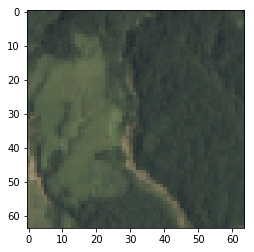

In [19]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

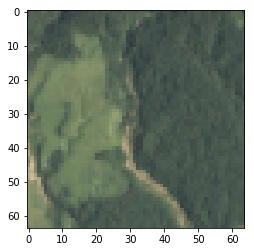

In [20]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] * 1.3 ) # TIP : Multiply by a value if the image is too hazy

In [21]:
data = get_data(size)

In [22]:
data = data.resize(int(size*1.3), 'tmp')

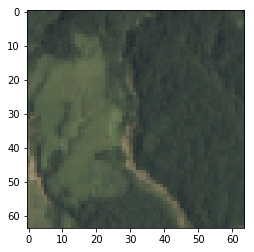

In [23]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

## Train model

In [24]:
learn = ConvLearner.pretrained(arch, data, metrics=metrics, precompute=False)

In [25]:
lrf = learn.lr_find()

epoch      trn_loss   val_loss   f2                          
    0      0.230754   0.306451   0.822704  



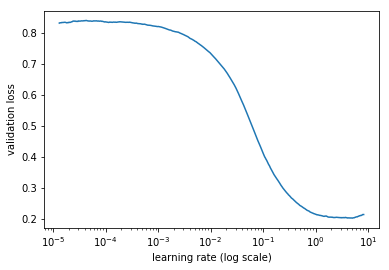

In [26]:
learn.sched.plot()

In [27]:
?? metrics

In [28]:
learning_rate = 0.1

In [29]:
%time learn.fit(learning_rate, 3, cycle_len=1, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.150331   0.134246   0.880148  
    1      0.145438   0.128329   0.887281                    
    2      0.138333   0.125677   0.890335                    

CPU times: user 7min 22s, sys: 12min 55s, total: 20min 17s
Wall time: 2min 45s


[array([0.12568]), 0.8903354304533002]

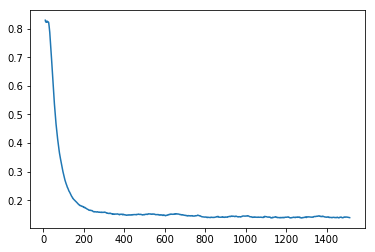

In [30]:
learn.sched.plot_loss()

##### As sat images are not part of imagnet, we divide by smaller numbers as we want to train the entire network from scratch. Well kind of, we initially use the weights from imagnet model as something is better than nothing and also, imagnet initial layers actually detect basic structures like edges etc.

In [31]:
learning_rates = np.array([learning_rate/9, learning_rate/3, learning_rate]) 

In [32]:
learn.unfreeze()

In [33]:
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.120684   0.108165   0.907802  
    1      0.115555   0.101905   0.915456                    
    2      0.105072   0.098748   0.917583                    
    3      0.108608   0.100696   0.915097                    
    4      0.105521   0.097015   0.920042                     
    5      0.099386   0.095165   0.9208                       
    6      0.096606   0.094566   0.921145                     

CPU times: user 33min 39s, sys: 1h 9min 1s, total: 1h 42min 41s
Wall time: 14min 3s


[array([0.09457]), 0.9211448883870321]

In [34]:
%time learn.save(f'{project_name}_last_layer_{size}')

CPU times: user 92 ms, sys: 344 ms, total: 436 ms
Wall time: 104 ms


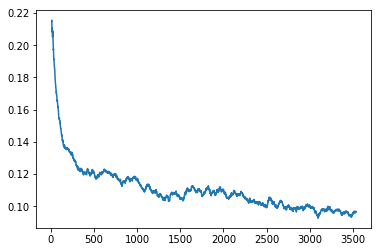

In [35]:
learn.sched.plot_loss()

### Increase pic size

In [36]:
size = 128

epoch      trn_loss   val_loss   f2                           
    0      0.09436    0.091824   0.922847  
    1      0.093001   0.090338   0.924048                     
    2      0.092077   0.089843   0.924806                     
    3      0.091783   0.090029   0.924054                     
    4      0.092321   0.089533   0.924788                     
    5      0.08921    0.088701   0.925733                     
    6      0.089375   0.088611   0.92577                      

CPU times: user 27min 29s, sys: 3min 44s, total: 31min 14s
Wall time: 11min 56s


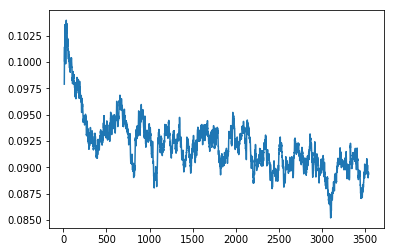

In [37]:
learn.set_data(get_data(size))
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, metrics=metrics)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.088166   0.085568   0.92931   
    1      0.088768   0.085405   0.929719                     
    2      0.082878   0.08464    0.929457                     
    3      0.089735   0.087072   0.928513                     
    4      0.085187   0.084937   0.928837                     
    5      0.081622   0.083549   0.931238                     
    6      0.07938    0.083394   0.930993                     

CPU times: user 42min 41s, sys: 7min 51s, total: 50min 32s
Wall time: 31min 7s


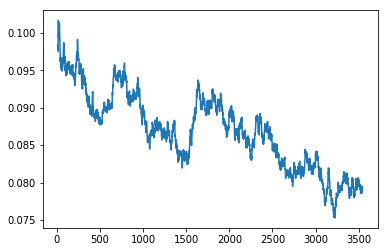

In [38]:
learn.unfreeze()
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()
learn.save(f'{project_name}_last_layer_{size}')

#### 256 size

In [9]:
size = 256

In [40]:
learn.set_data(get_data(size))
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, metrics=metrics)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.084022   0.086916   0.92739   
    1      0.085969   0.086453   0.927947                     
    3      0.083257   0.086633   0.927733                     
    4      0.08632    0.08656    0.927739                     
    5      0.081971   0.08595    0.928694                     
  4%|▍         | 20/506 [00:13<05:17,  1.53it/s, loss=0.0818]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

    1      0.085279   0.08292    0.932809                     
    2      0.078587   0.081582   0.933742                     
    3      0.083253   0.083772   0.930384                     
  2%|▏         | 9/506 [00:17<16:10,  1.95s/it, loss=0.0837]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      0.073734   0.081391   0.933184                     

CPU times: user 1h 56min 52s, sys: 28min 20s, total: 2h 25min 13s
Wall time: 1h 46min 5s


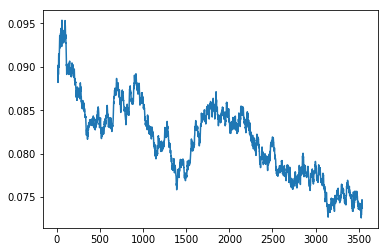

In [41]:
learn.unfreeze()
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()
learn.save(f'{project_name}_last_layer_{size}')

In [ ]:
learn = learn.load((f'{project_name}_last_layer_{size}'))

In [1]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

NameError: name 'learn' is not defined

In [50]:
print(multi_preds.shape)
print(preds.shape)
print(y.shape)

(5, 8095, 17)
(8095, 17)
(8095, 17)


In [51]:
preds[0]

array([0.64672, 0.0014 , 0.04165, 0.00045, 0.00059, 0.99985, 0.00014, 0.00039, 0.3066 , 0.0224 , 0.00034,
       0.00002, 0.99853, 0.17332, 0.00243, 0.01112, 0.71339], dtype=float32)

In [ ]:
y[0]

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [46]:
# f2(preds,y)

In [47]:
#tta = learn.TTA()

In [48]:
# f2(*tta)

ValueError: Found input variables with inconsistent numbers of samples: [8095, 5]

In [ ]:
test_multi_preds, test_y = learn.TTA(is_test=True) # doesn't return test_y for test set as the label is to be predicted!
test_preds = np.mean(test_multi_preds, 0)

In [ ]:
print(test_multi_preds.shape)
print(test_preds.shape)
print(test_y.shape)

In [ ]:
test_y.max()

In [ ]:
test_preds[0]

In [ ]:
test_preds[240]

In [ ]:
test_probs = np.round(test_preds)

In [ ]:
test_probs.shape

In [ ]:
test_probs[0]

In [ ]:
print(test_probs[240]) # all zeros?

In [ ]:
f2(test_preds, test_probs)

In [ ]:
#def get_test_classes(probs, classes):
#    prob_idxs = np.argwhere(probs==1) # Indexs of 1's in every row of probs ([0 1 0 1 0 1 0])
#    prob_idxs = prob_idxs.flatten().tolist() # Convert the o/p to a list after flatting it as required by itemgetter
    #return operator.itemgetter(*prob_idxs)(classes) 

In [ ]:
def get_test_classes(probs, classes):
    prob_idxs = np.argwhere(probs==1) # Indexs of 1's in every row of probs ([0 1 0 1 0 1 0])
    prob_idxs = prob_idxs.flatten().tolist() # Convert the o/p to a list after flatting it as required by itemgetter

    all_probs_zero = 0
    if not prob_idxs:
        all_probs_zero =+ 1
        prob_idxs = [10]  # default to haze

    if all_probs_zero != 0: print("All 0 probs : {}".format(all_probs_zero))
    #return operator.itemgetter(*(np.argwhere(probs==1)).flatten().tolist())(classes)    

    classes = operator.itemgetter(*prob_idxs)(classes)
    # If there is just one class, then the itemgetter returns a string instead of a tuple
    # Convert to tuple. Else, the join will put a space in between every letter in the aingle word.
    # E.g.: c l o u d y instead of cludy
    if type(classes) == str: classes = (classes,) 
        
    return classes

In [ ]:
a = get_test_classes(test_probs[4], learn.data.classes)
print(type(a))
print(len(a))
a

In [ ]:
#operator.itemgetter(a)(learn.data.classes) 
#test_classes = [' '.join( get_test_classes(probs, learn.data.classes) ) for probs in test_probs]
#[print( ' '.join( operator.itemgetter(*(np.argwhere(a==1)).flatten().tolist())(learn.data.classes) ) ) for a in test_probs[230:250]]
#test_classes = [' '.join( operator.itemgetter(*(np.argwhere(a==1)).flatten().tolist())(learn.data.classes) )  for a in test_probs]

In [ ]:

test_classes = [ ' '.join( get_test_classes(probs, learn.data.classes) ) for probs in test_probs]


In [ ]:
test_classes[:5]
#print(len(test_classes))

In [ ]:
fn = PATH + get_data(224).test_ds.fnames[240]
fn

In [ ]:
fnames = [f[9:-4] for f in learn.data.test_ds.fnames]
len(fnames)

In [ ]:
fnames[240]

In [ ]:
subm = np.stack([fnames, test_classes], axis=1)
subm[:5]

In [ ]:
test_df = pd.DataFrame(subm)

In [ ]:
test_df.head()

In [ ]:
#test_df.insert(0, 'image_name', fnames )

# Submit to kaggle

In [ ]:
!pwd

In [ ]:
now = datetime.datetime.now()
submission_file_name = f'{project_name}-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, subm, fmt='%s,%s', header='image_name,tags', comments='')

In [ ]:
from IPython.display import FileLink
FileLink(submission_file_name)

In [ ]:
!date